## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
keras = tf.keras

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
def timeseries_dataset(series, window_size, batch_size=32):
    """
    This function creates a TimeseriesGenerator object that can be used to generate batches of data from a time series.
    """
    series = np.expand_dims(series, axis=-1)
    generator = keras.preprocessing.sequence.TimeseriesGenerator(
        data=series[:-1],
        targets=series[1:],
        length=window_size,
        batch_size=batch_size,
    )
    return generator
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [20]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [4]:
path = r'C:\Users\adria\1Python\Meu_novo_projeto\WIN_N_1K\WIN_N_1k.csv'
raw = pd.read_csv(path, index_col=0, parse_dates=True)

In [5]:
df = pd.DataFrame()

In [6]:
df['media'] = (raw['high'] + raw['low']) / 2

In [7]:
media_movel = df['media'].rolling(window=2).mean()

In [8]:
df['media_movel'] = media_movel

In [9]:
df

,close,media_movel
time,,
2022-01-18 11:38:00,106667.5,NaN
2022-01-18 11:39:00,106745.0,106706.25
2022-01-18 11:40:00,106767.5,106756.25
2022-01-18 11:41:00,106787.5,106777.50
2022-01-18 11:42:00,106882.5,106835.00
...,...,...
2022-10-13 16:55:00,114917.5,114917.50
2022-10-13 16:56:00,114917.5,114917.50
2022-10-13 16:57:00,114917.5,114917.50


In [10]:
df['r'] = df['media_movel'].pct_change()

In [11]:
df = df.dropna()

series = df['r'].values

time = np.arange(len(series))

In [12]:
len(series)

99997

In [13]:
len(time)

99997

In [15]:
split_time = 70000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## WaveNet

In [16]:
%%time
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = timeseries_dataset(x_train, window_size, batch_size=128)
valid_set = timeseries_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam()
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
547/547 [==============================] - 19s 14ms/step - loss: 8.8690e-08 - mse: 1.7738e-07 - val_loss: 9.4747e-08 - val_mse: 1.8949e-07
Epoch 2/500
547/547 [==============================] - 7s 13ms/step - loss: 8.0637e-08 - mse: 1.6127e-07 - val_loss: 8.3165e-08 - val_mse: 1.6633e-07
Epoch 3/500
547/547 [==============================] - 7s 13ms/step - loss: 8.0488e-08 - mse: 1.6098e-07 - val_loss: 1.6034e-07 - val_mse: 3.2069e-07
Epoch 4/500
547/547 [==============================] - 7s 14ms/step - loss: 8.1622e-08 - mse: 1.6324e-07 - val_loss: 8.7489e-08 - val_mse: 1.7498e-07
Epoch 5/500
547/547 [==============================] - 7s 13ms/step - loss: 7.9699e-08 - mse: 1.5940e-07 - val_loss: 8.4481e-08 - val_mse: 1.6896e-07
Epoch 6/500
547/547 [==============================] - 7s 14ms/step - loss: 8.1087e-08 - mse: 1.6217e-07 - val_loss: 8.1413e-08 - val_mse: 1.6283e-07
Epoch 7/500
547/547 [==============================] - 8s 14ms/step - loss: 8.0281e-08 - mse: 1.605

547/547 [==============================] - 8s 14ms/step - loss: 8.0403e-08 - mse: 1.6081e-07 - val_loss: 1.1339e-07 - val_mse: 2.2679e-07
Epoch 110/500
547/547 [==============================] - 7s 13ms/step - loss: 7.6394e-08 - mse: 1.5279e-07 - val_loss: 1.1360e-07 - val_mse: 2.2720e-07
Epoch 111/500
547/547 [==============================] - 7s 14ms/step - loss: 7.5839e-08 - mse: 1.5168e-07 - val_loss: 1.1445e-07 - val_mse: 2.2890e-07
Epoch 112/500
547/547 [==============================] - 7s 13ms/step - loss: 7.7883e-08 - mse: 1.5577e-07 - val_loss: 8.1157e-08 - val_mse: 1.6231e-07
Epoch 113/500
547/547 [==============================] - 8s 14ms/step - loss: 7.6719e-08 - mse: 1.5344e-07 - val_loss: 8.3559e-08 - val_mse: 1.6712e-07
Epoch 114/500
547/547 [==============================] - 8s 14ms/step - loss: 7.6544e-08 - mse: 1.5309e-07 - val_loss: 8.1146e-08 - val_mse: 1.6229e-07
Epoch 115/500
547/547 [==============================] - 8s 14ms/step - loss: 7.6318e-08 - mse: 1.5264

In [17]:
model = keras.models.load_model("my_checkpoint.h5")

In [18]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

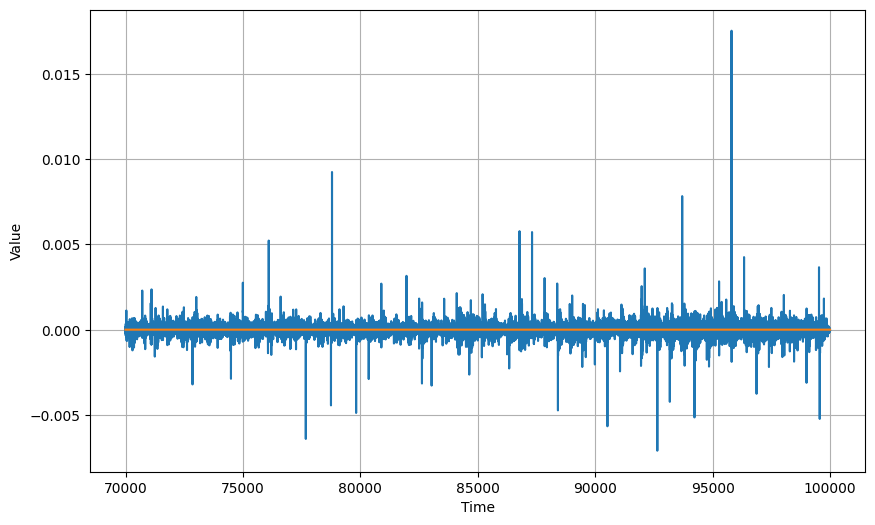

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [22]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

0.00024140191

In [23]:
keras.metrics.mean_squared_error(x_valid, cnn_forecast).numpy()

1.6154935e-07

In [24]:
df2 = pd.DataFrame()

df2['diff_moving_avg_plus_past'] = cnn_forecast
df2['x_valid'] = x_valid

ultimo_preco_fechamento = 113630.0

df2['preco_valid'] = (1 + df2['x_valid']).cumprod()
df2['preco_valid'] = ultimo_preco_fechamento * df2['preco_valid']

df2['desr_prev'] = (1 + df2['diff_moving_avg_plus_past']).cumprod()
df2['desr_prev'] = ultimo_preco_fechamento * df2['desr_prev']

In [25]:
df2

,diff_moving_avg_plus_past,x_valid,preco_valid,desr_prev
0,0.000004,-0.000174,113610.282839,113630.445312
1,0.000004,-0.000074,113601.832627,113630.890625
2,0.000004,0.000149,113618.733051,113631.343750
3,0.000004,-0.000037,113614.507945,113631.789062
4,0.000004,-0.000136,113599.015890,113632.234375
...,...,...,...,...
29992,0.000004,-0.000011,129476.964131,127857.320312
29993,0.000004,0.000000,129476.964131,127857.820312
29994,0.000004,0.000000,129476.964131,127858.320312
29995,0.000004,-0.000011,129475.555762,127858.820312


In [26]:
len(x_valid)

29997

In [27]:
len(x_train)

70000

In [28]:
df2['diff'] = df2['preco_valid']-df2['desr_prev']

In [29]:
df2['diff'].mean()

4762.245806314424